# Feature Selection

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from google.colab import files
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
uploaded1 = files.upload()

Saving BTC_feature_engineered_data_27.csv to BTC_feature_engineered_data_27.csv


In [4]:
btc_data_27 = pd.read_csv('BTC_feature_engineered_data_27.csv')

In [5]:
# function to convert datatype to float32
def convert_to_float32(df):
  for i in range(len(df.columns)):
    if df[df.columns[i]].dtype == 'float64':
      df[df.columns[i]] = np.nan_to_num(df[df.columns[i]].astype(np.float32))
  return df

In [6]:
btc_data_27 = convert_to_float32(btc_data_27)

In [17]:
# Creating blocks for each set of smoothening range and technical indicators
blocks = []
technical_indicators = np.array(['sma','wma','ema','tema','dema','rsi','std','roc','mom','var','BBupper','BBmiddle','BBlower'])
smoothening_range = np.array(['7','30','90'])
for p in smoothening_range:
  for t in technical_indicators:
    string = p + t
    blocks.append(string)

In [18]:
# Function to select technical features
def tech_feature_selection(x,y):
  """ 
      this function selects most important feature from each block
  """
  list_of_selected_features=[]
  for string in blocks:
    print('Block:',string)
    new_df=x.filter(like=string,axis=1)
    new_df = pd.DataFrame(new_df)
    new_df.columns=x.filter(like=string,axis=1).columns
    estimator = RandomForestRegressor(random_state=42)
    selector = RFECV(estimator, step=0.6,verbose=True,scoring='neg_mean_absolute_error',n_jobs=-1)
    selector = selector.fit(new_df, y)
    mask = selector.get_support()
    new_features = new_df.columns[mask]
    print('Feature Rankings',selector.ranking_)
    if len(new_features.values)>1:
      estimator.fit(new_df, y)
      for j in range(len(estimator.feature_importances_)):
        if estimator.feature_importances_.max() == estimator.feature_importances_[j]:
          new_features = new_df.columns[j]
          print('Selected Feature:', new_features)
          list_of_selected_features.append(new_features)
    else:
      features = new_features.values
      for i in features:
        print(i)
        list_of_selected_features.append(i)
    print('Number of Selected Features:', len(list_of_selected_features))
    print('*'*50)
  return list_of_selected_features


In [19]:
x_btc_data_27 = btc_data_27.drop(['next_day_BTC_price'], axis=1)
y_btc_data_27 = btc_data_27['next_day_BTC_price']

In [21]:
list_of_selected_features_27 = tech_feature_selection(x_btc_data_27,y_btc_data_27)

Block: 7sma
Fitting estimator with 25 features.
Fitting estimator with 10 features.
Feature Rankings [3 3 3 3 3 3 2 3 3 3 3 2 3 3 3 2 3 2 3 2 2 2 1 2 2]
Close_7sma
Number of Selected Features: 1
**************************************************
Block: 7wma
Fitting estimator with 25 features.
Fitting estimator with 10 features.
Feature Rankings [3 3 3 2 3 3 3 3 3 3 3 2 3 3 3 2 3 2 3 2 2 2 1 2 2]
Close_7wma
Number of Selected Features: 2
**************************************************
Block: 7ema
Fitting estimator with 25 features.
Fitting estimator with 10 features.
Feature Rankings [3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 2 3 2 2 2 2 1 2 2 2]
Low_7ema
Number of Selected Features: 3
**************************************************
Block: 7tema
Fitting estimator with 25 features.
Fitting estimator with 10 features.
Feature Rankings [3 3 3 2 3 3 3 3 3 3 2 2 3 3 3 2 3 2 3 2 2 2 1 3 2]
Close_7tema
Number of Selected Features: 4
**************************************************
Block: 7dema
Fit

In [22]:
# Function that measures Variance Inflation Factor
def VIF(data):
  vif_data = pd.DataFrame()
  vif_data["feature_vif"] = data.columns
  # calculating vif for each feature in train dataset
  vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
  return vif_data.sort_values(['VIF'],ascending = False)

In [29]:
btc_data_27_raw = btc_data_27.iloc[:,1:26]

In [30]:
btc_data_27_raw.columns

Index(['transactions', 'size', 'sentbyaddress', 'difficulty', 'hashrate',
       'mining_profitability', 'sentinusd', 'transactionfees',
       'median_transaction_fee', 'confirmationtime', 'transactionvalue',
       'tweets', 'google_trends', 'mediantransactionvalue', 'activeaddresses',
       'top100cap', 'fee_to_reward', 'avg_price', 'fear_gear_index', 'Open',
       'High', 'Low', 'Close', 'miners_revenue', 'coins_in_supply'],
      dtype='object')

In [31]:
btc_data_27_tech = btc_data_27[list_of_selected_features_27]

In [34]:
VIF_27_tech = VIF(btc_data_27_tech)
tech_27 = btc_data_27[VIF_27_tech['feature_vif'].to_list()]

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1638: RuntimeWarning: invalid value encountered in float_scalars
  return 1 - self.ssr/self.uncentered_tss


In [36]:
tech_27.shape

(1231, 39)

In [37]:
VIF_27_raw = VIF(btc_data_27_raw)
raw_27 = btc_data_27_raw.copy()
raw_27.drop(VIF_27_raw[VIF_27_raw['VIF']>10]['feature_vif'].to_list(),axis=1,inplace=True)

In [38]:
raw_27.shape

(1231, 17)

In [39]:
data_27 = raw_27.join(tech_27)

In [40]:
data_27.shape

(1231, 56)

In [81]:
regr_27=RandomForestRegressor(random_state=42)
regr_27.fit(data_27,y_btc_data_27)
fea_imp_27 = pd.DataFrame({'Features':data_27.columns,'Feature_importances':list(regr_27.feature_importances_)}).sort_values(by = ['Feature_importances'],ascending=False)


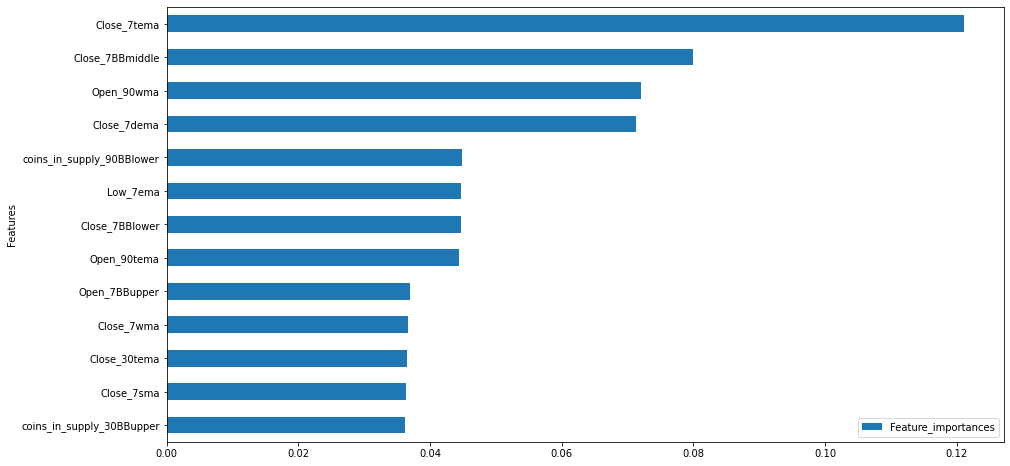

In [82]:
fea_imp_27.sort_values(['Feature_importances'], ascending=[True]).tail(13).plot.barh(x='Features', y='Feature_importances',figsize=(15,8))

In [50]:
selected_features_27 = fea_imp_27.iloc[:15,:-1]['Features'].to_list()

In [51]:
selected_features_27.insert(0, 'Date')
selected_features_27.insert(len(selected_features_27)+1, 'next_day_BTC_price')

In [52]:
selected_features_27

['Date',
 'Close_7tema',
 'Close_7BBmiddle',
 'Open_90wma',
 'Close_7dema',
 'coins_in_supply_90BBlower',
 'Low_7ema',
 'Close_7BBlower',
 'Open_90tema',
 'Open_7BBupper',
 'Close_7wma',
 'Close_30tema',
 'Close_7sma',
 'coins_in_supply_30BBupper',
 'coins_in_supply_90BBupper',
 'Open_30ema',
 'next_day_BTC_price']

In [53]:
data_selected_final_27 = btc_data_27[selected_features_27]

In [54]:
data_selected_final_27.to_csv('data_selected_final_27.csv', sep=',',index= False)